In [1]:
import pyaudio
import wave
import datetime
import os, sys
import soundfile as sf
os.chdir("C:\\Users\\User\\Documents\\comparing_acoustic_deep_neural_networks\\")

import csv, os, glob
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sys.path.append('src')
sys.path.append('src/models')
from models.get_models import get_model
import models.yamnet_tf2.params as params
params = params.Params(sample_rate=16000, patch_hop_seconds=0.256) # 0.25
import dataload_utils.data_load as data_load

parent_dir = "C:/Users/User/Documents/cer_dataset_16k_resampled_split\\"
dataset_loader = data_load.Dataset_loader(parent_dir, params)
filenames_all = dataset_loader.__filenames_all__
classes = dataset_loader.__classes__
num_classes = dataset_loader.__num_classes__
print("classes: {}, num_classes: {}".format(classes, num_classes))

MODEL_NAME="YAMNET"
model = get_model(MODEL_NAME)
ckp_path = "C:\\Users\\User\\Documents\\comparing_acoustic_deep_neural_networks\\training\\20220416-150422_main\\YAMNET\\checkpoints\\cp.ckpt"
model.load_weights(ckp_path)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(), #from_logits=True
    metrics=['accuracy'],
)



Number of files in Class_00_Modified_car_engines: 8071
Number of files in Class_01_Regular_Vehicles: 9539
Number of files in Class_02_Tools_and_Mechanisms: 13307
Number of files in Class_03_Environmental_Sounds: 10488
Number of files:  41405
classes: ['Class_00_Modified_car_engines', 'Class_01_Regular_Vehicles', 'Class_02_Tools_and_Mechanisms', 'Class_03_Environmental_Sounds'], num_classes: 4


In [2]:
import glob
import librosa
import matplotlib.pyplot as plt
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

top_n = 4

def plot_filename(filename):
    # wav, sr = librosa.load(filename, sr=16000)
    # waveform = tf.cast(wav, dtype=tf.float32)
    waveform = dataset_loader._get_waveform_no_label(filename)
    spec, melspec = dataset_loader.get_embeddings_and_features(filename) 
    scores = np.array(model.predict(melspec))
    
    plt.figure(figsize=(10, 6))

    # Plot the waveform.
    plt.subplot(3, 1, 1)
    plt.plot(waveform)
    plt.xlim([0, len(waveform)])

    # Plot the log-mel spectrogram (returned by the model).
    plt.subplot(3, 1, 2)
    plt.imshow(spec.numpy().T, aspect='auto', interpolation='nearest', origin='lower')

    # Plot and label the model output scores for the top-scoring classes.
    mean_scores = np.mean(scores, axis=0)
    # top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
    top_class_indices=np.arange(top_n)
    plt.subplot(3, 1, 3)
    # plt.imshow(scores[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

    score_map = (scores[:, top_class_indices].T)
    max_score = np.argmax(score_map, axis=0)
    max_score_onehot = tf.one_hot(max_score,6).numpy().T
    # score_map_top1 = np.zeros(score_map.shape)
    plt.imshow(score_map)
    # plt.imshow(max_score_onehot,alpha=0.6)

    # patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
    # values from the model documentation
    patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
    plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
    # Label the top_N classes.
    yticks = range(0, top_n, 1)
    plt.yticks(yticks, [classes[top_class_indices[x]] for x in yticks])
    _ = plt.ylim(-0.5 + np.array([top_n, 0]))

FILENAME_ALL_LENGTH = len(filenames_all)

In [3]:
# import random
# import librosa
# import scipy

# filename = filenames_all[random.randint(0,FILENAME_ALL_LENGTH)]
# wav = dataset_loader._get_waveform_no_label(filename)
# spec, melspec = dataset_loader.get_embeddings_and_features(filename) 
# scores = tf.argmax(model.predict(melspec), axis=1)
# most_scored = scipy.stats.mode(scores)
# print("Predictions for each embedding: {}, \
#     \nPrediction Class name: {} \nReal Class and file name: {}".format(
#         scores, classes[most_scored.mode[0]], filename.split("split\\")[-1]
#         ))
# plot_filename(filename)
# os.system("python play_sound.py -f {}".format(filename))

In [4]:
import glob
import librosa
import matplotlib.pyplot as plt
from tkinter import TclError
import time
# to display in separate Tk window
%matplotlib tk

COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

test_save_files_path = "./test_save_files/"
top_n = 4

PATCH_WINDOW_SECONDS = 0.96
PATCH_HOP_SECONDS = PATCH_WINDOW_SECONDS/4

first_loop_flag=True
for i in range(1000):
    try:
        filename = os.listdir(test_save_files_path)[-2]
        filename = test_save_files_path + filename
        print("Processing file: {}".format(filename))

        wav, sr = librosa.load(filename, sr=16000)
        # wav = get_waveform_no_label(filename)
        waveform = tf.cast(wav, dtype=tf.float32)
        # waveform = dataset_loader._get_waveform_no_label(filename)
        spec, melspec = dataset_loader.get_embeddings_and_features_librosa(filename) 
        # !del /S .\test_save_files\**"    
        scores = np.array(model.predict(melspec))
        
        if first_loop_flag==True:

            # fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 6))
            fig, ax = plt.subplots(3, figsize=(10, 10))
            ax=ax.flatten()
            wave_plot, = ax[0].plot(waveform)
            ax[0].axis(xmin=0,xmax=len(waveform), ymin=-1, ymax=1) #xlim([0, len(waveform)])

            spec_plot = ax[1].imshow(spec.numpy().T, aspect='auto', interpolation='nearest', origin='lower')
            score_map = (scores.T)
            max_score = np.argmax(score_map, axis=0)
            max_score_onehot = tf.one_hot(max_score,4).numpy().T
            
            score_plot = ax[2].imshow(max_score_onehot)
            patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
            ax[2].axis(xmin=0, xmax=score_map.shape[1])
            # ax[2].axis(xmin=-patch_padding-0.5,xmax=score_map.shape[1] + patch_padding-0.5) # xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
            # Label the top_N classes.
            top_class_indices = np.arange(4)
            # yticks = np.arange(6,0,-1)-0.5
            yticks=np.arange(4)
            ax[2].set_yticks(yticks, classes)
            _ = ax[2].axis(ymax=-0.5, ymin=top_n-0.5) #.()ylim
            # _ = ax[2].axis(ymax=-0.5, ymin=-0.5 + top_n) #.()ylim
            first_loop_flag=False

        # Plot the waveform.
        wave_plot.set_ydata(waveform)
        # Plot the log-mel spectrogram (returned by the model).
        spec_plot.set_data(spec.numpy().T)
        # Plot and label the model output scores for the top-scoring classes.
        score_map = (scores.T)
        max_score = np.argmax(score_map, axis=0)
        max_score_onehot = tf.one_hot(max_score,4).numpy().T
        score_plot.set_data(score_map)# ,alpha=0.6)
        # score_plot.set_xlabel("Most Recent Prediction: {}".format(classes[np.argmax(max_score_onehot[:,-1])]))
                # score_plot.set_alpha(0.6)
        # score_plot.set_data(max_score_onehot)# ,alpha=0.6)
        fig.canvas.draw()
        fig.canvas.flush_events()

    except:
        print("Error")

Processing file: ./test_save_files/output_2022-04-18_14-49-35-064032.wav
Processing file: ./test_save_files/output_2022-04-18_14-49-40-954080.wav
Processing file: ./test_save_files/output_2022-04-18_14-49-41-934118.wav
Processing file: ./test_save_files/output_2022-04-18_14-49-42-914109.wav
Processing file: ./test_save_files/output_2022-04-18_14-49-43-893959.wav
Processing file: ./test_save_files/output_2022-04-18_14-49-44-884001.wav
Processing file: ./test_save_files/output_2022-04-18_14-49-45-863954.wav
Processing file: ./test_save_files/output_2022-04-18_14-49-46-844101.wav
Processing file: ./test_save_files/output_2022-04-18_14-49-46-844101.wav
Processing file: ./test_save_files/output_2022-04-18_14-49-47-824487.wav
Processing file: ./test_save_files/output_2022-04-18_14-49-48-804606.wav
Processing file: ./test_save_files/output_2022-04-18_14-49-49-784276.wav
Processing file: ./test_save_files/output_2022-04-18_14-49-50-764371.wav
Processing file: ./test_save_files/output_2022-04-1

Error: Canceled future for execute_request message before replies were done

In [ ]:
filename = "./test_save_files/" + filename

wav, sr = librosa.load(filename, sr=16000)
# wav = get_waveform_no_label(filename)
waveform = tf.cast(wav, dtype=tf.float32)
# waveform = dataset_loader._get_waveform_no_label(filename)
spec, melspec = dataset_loader.get_embeddings_and_features_librosa(filename) 
# !del /S .\test_save_files\**"    
scores = np.array(model.predict(melspec))

C:\ProgramData\Miniconda3\envs\usc39\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: [Errno 2] No such file or directory: './test_save_files/./test_save_files/output_2022-04-18_14-23-04-831778.wav'

Number of files in Class_00_Modified_car_engines: 8071
Number of files in Class_01_Regular_Vehicles: 9539
Number of files in Class_02_Tools_and_Mechanisms: 13307
Number of files in Class_03_Environmental_Sounds: 10488
Number of files:  41405


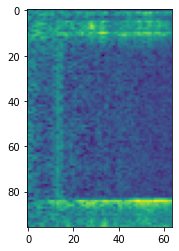

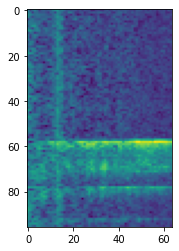

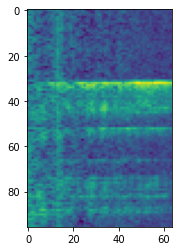

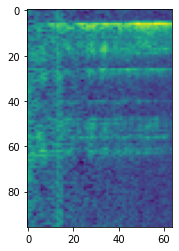

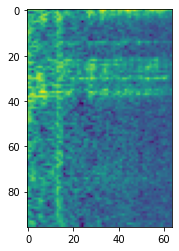

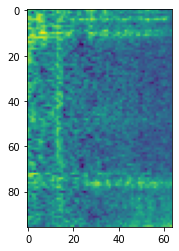

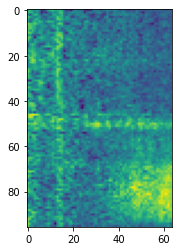

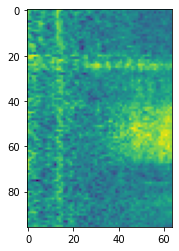

In [ ]:
filename = os.listdir(test_save_files_path)[-2]
filename = test_save_files_path + filename

import models.yamnet_tf2.params as params
params = params.Params(sample_rate=16000, patch_hop_seconds=0.256) # 0.25
dataset_loader = data_load.Dataset_loader(parent_dir, params)
spec, melspec = dataset_loader.get_embeddings_and_features_librosa(filename) 
%matplotlib inline
for i in melspec:
    plt.imshow(i)
    plt.show()
# filename = os.listdir(test_save_files_path)[-2]
# filename = test_save_files_path + filename
# filename